In [653]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import random
import re
import seaborn as sns
%matplotlib inline

In [654]:
charts = pd.read_csv('2019_top_100.csv')

## Data Handling

In [655]:
# Convert start_date and end_date to datetime objects
charts['start_date']= pd.to_datetime(charts['start_date'], format='%d.%m.%Y')
charts['end_date']= pd.to_datetime(charts['end_date'], format='%d.%m.%Y')

In [656]:
# Add column week
charts['week'] = charts['start_date'].dt.week

In [657]:
# Add combination of artist and song (easier for plotting purposes later)
charts['artist_song'] = charts['artist'] + ' - ' + charts['song']

In [658]:
# Add column with peak position of the song during the year
tracks = charts.artist_song.unique()
peak_positions = charts.groupby(['artist_song'])['position'].min()

for track in tracks:
    charts.loc[charts['artist_song'] == track, 'peak'] = peak_positions[track]

In [802]:
# Add column to mark if a song was in the top10 during the year (1: yes, 0: no)
charts['top10'] = charts['peak'].apply(lambda x: 1 if x<=10 else 0)

In [803]:
charts.head()

,artist,song,label,position,start_date,end_date,week,artist_song,peak,top10
0,Capital Bra,Benzema,Universal Domestic Urban,1,2018-12-28,2019-01-03,52,Capital Bra - Benzema,1.0,1
1,Mariah Carey,All I Want For Christmas Is You,SME - Columbia,2,2018-12-28,2019-01-03,52,Mariah Carey - All I Want For Christmas Is You,1.0,1
2,Wham!,Last Christmas,SME - Epic,3,2018-12-28,2019-01-03,52,Wham! - Last Christmas,2.0,1
3,Ava Max,Sweet But Psycho,Atlantic,4,2018-12-28,2019-01-03,52,Ava Max - Sweet But Psycho,1.0,1
4,Chris Rea,Driving Home For Christmas,Warner Music International,5,2018-12-28,2019-01-03,52,Chris Rea - Driving Home For Christmas,5.0,1


## Top Artists

In [660]:
# Number of times an artist appears in the charts for the year
counts = charts['artist'].value_counts().rename_axis('artist').reset_index(name='counts')


# Limit number of artists to the ones appearing more than 40 ones
top_artists = counts[counts['counts'] >= 40]

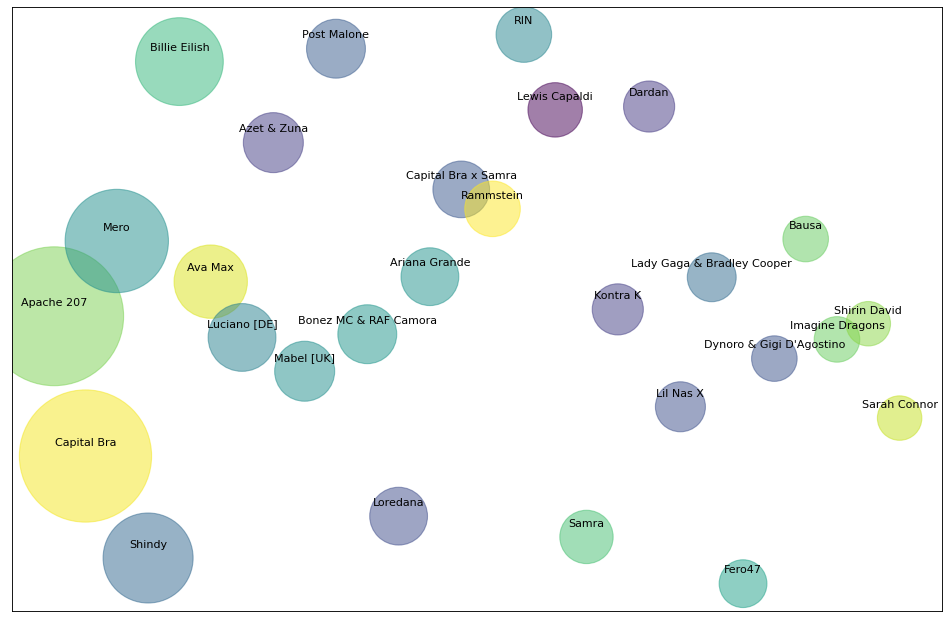

In [661]:
#Draw plot
plt.figure(figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')

x = top_artists['artist']
y = np.random.rand(len(x))                     # randomize position on the y-axis
colors = np.random.rand(len(x))                # randomize colors

plt.scatter(x, y,
            marker='o',
            s=top_artists['counts']**2,        # marker size depends on the number of times artist appears
            alpha=0.5,
            c=colors)


# Label points with artist name, called for each point
for i,j in zip(x,y):
    label = i
    plt.annotate(label,                        # this is the text
                 (i,j),                        # this is the point to label
                 textcoords="offset points",   # how to position the text
                 xytext=(0,10),                # distance from text to points (x,y)
                 ha='center')                  # horizontal alignment can be left, right or center

plt.xticks([], [])
plt.yticks([], [])

plt.show()

## Songs by Artist

In [662]:
# Function to see development of all songs by one artist during the year

def info_artist(artist_name):
    # Filter dataframe by requested artist
    df = charts[charts['artist'] == artist_name].sort_values(by='start_date').copy()
    # Select all songs by artist
    tracks = df.song.unique()
    
    plt.figure(figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')
    
    # Draw plot for each track
    for track in tracks:
        x = df[df['song'] == track]['start_date']
        y = df[df['song'] == track]['position']
        plt.scatter(x, y,
                    marker='o',
                    s=1000-y*10,   # marker size depends on the position of the track in the charts
                    alpha=.5,
                    label=track)

    plt.yticks(np.array([1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]))

    plt.legend(numpoints=1)

    ax = plt.gca()
    ax.invert_yaxis()

    plt.show()

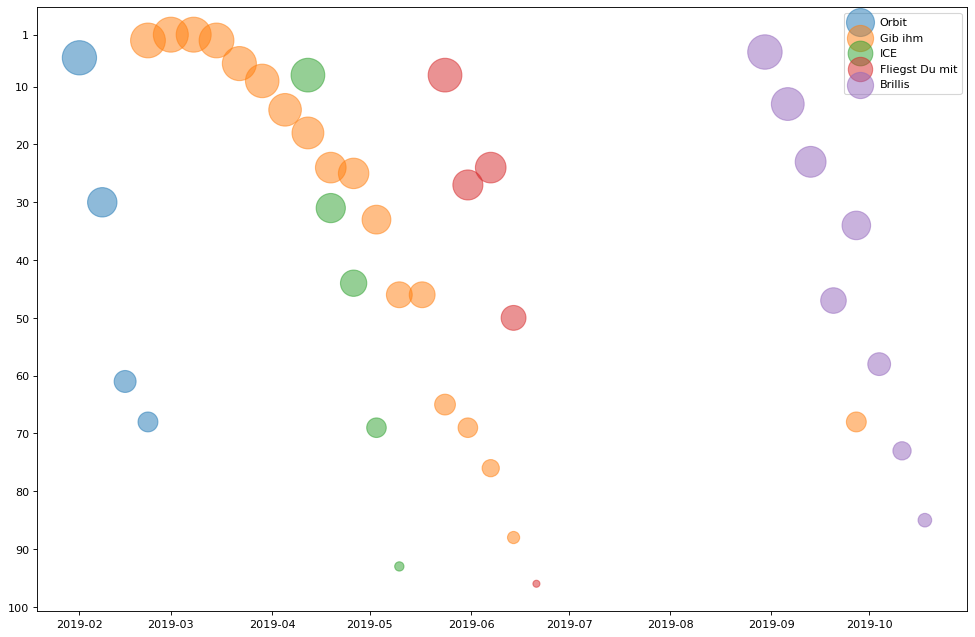

In [826]:
# Example
info_artist('Shirin David')

## No.1 Songs

In [664]:
# songs at the moment they were No.1
peak_position = charts['position'] == 1
peaks = charts[peak_position]

# all songs that were at least one week No.1
ones = charts['peak'] == 1
ones_other = charts[ones]

#### No.1 Songs during the Year

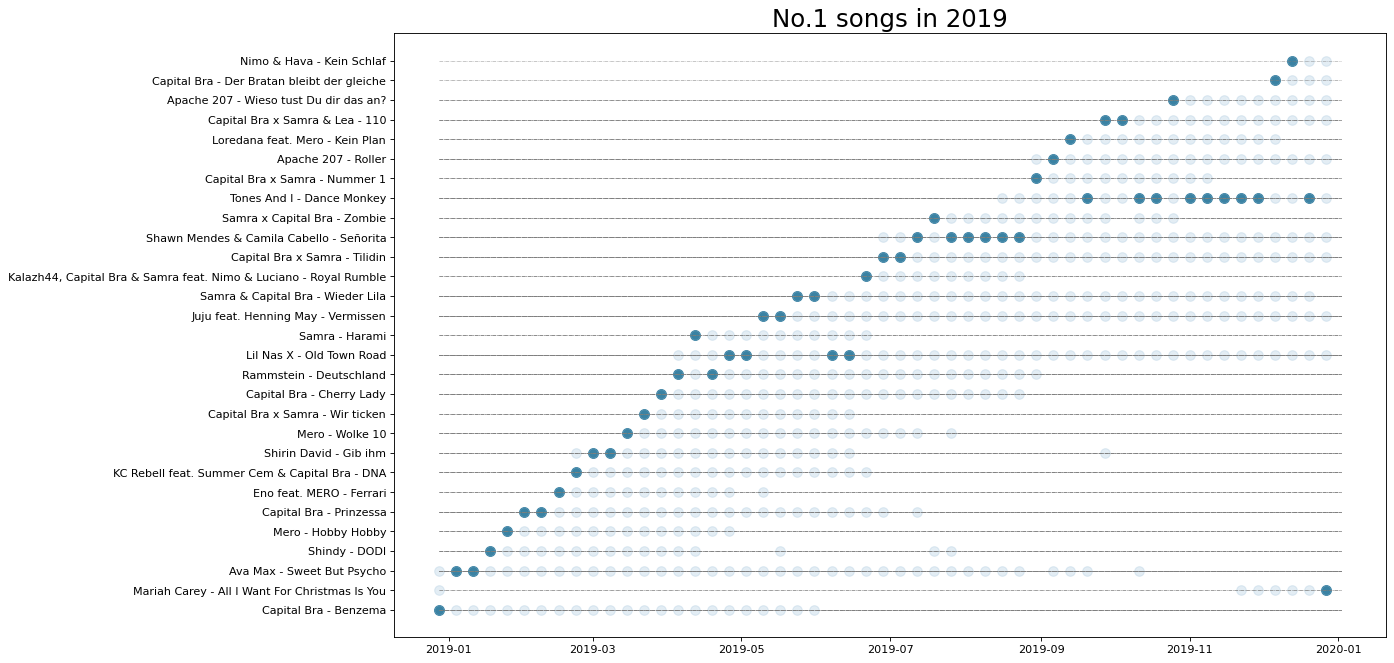

In [671]:
# Determine limits for x-axis
min_date = ones_other.start_date.min()
max_date = ones_other.end_date.max()

# Draw plot
fig, ax = plt.subplots(figsize=(16,10), dpi= 80)
ax.hlines(y=ones_other['artist_song'], xmin=min_date, xmax=max_date, color='gray', alpha=0.3, linewidth=0.5, linestyles='dashdot')
ax.scatter(y=peaks['artist_song'], x=peaks['start_date'], color='#0e668b', s=75)
ax.scatter(y=ones_other['artist_song'], x=ones_other['start_date'], s=75, color='#a3c4dc', alpha=0.3)

# Title
ax.set_title('No.1 songs in 2019', fontdict={'size':22})
plt.show()

#### No.1 weeks in charts

In [772]:
# Number of weeks song was in Top100
weeks_top100 = charts[ones].groupby(['artist_song'], as_index=False).count()[['artist_song', 'week']]

# Number of weeks song was on No.1
weeks_no1 = charts[peak_position].groupby(['artist_song'], as_index=False).count()[['artist_song', 'week']]

weeks = weeks_top100.merge(weeks_no1, how='left', on='artist_song')

weeks.columns = ['artist_song', 'weeks_in_charts', 'weeks_on_one']
weeks.sort_values(by=['weeks_in_charts'], inplace=True)
weeks.tail()

,artist_song,weeks_in_charts,weeks_on_one
25,Shawn Mendes & Camila Cabello - Señorita,27,6
22,Samra & Capital Bra - Wieder Lila,31,2
12,Juju feat. Henning May - Vermissen,34,2
15,Lil Nas X - Old Town Road,39,4
2,Ava Max - Sweet But Psycho,39,2


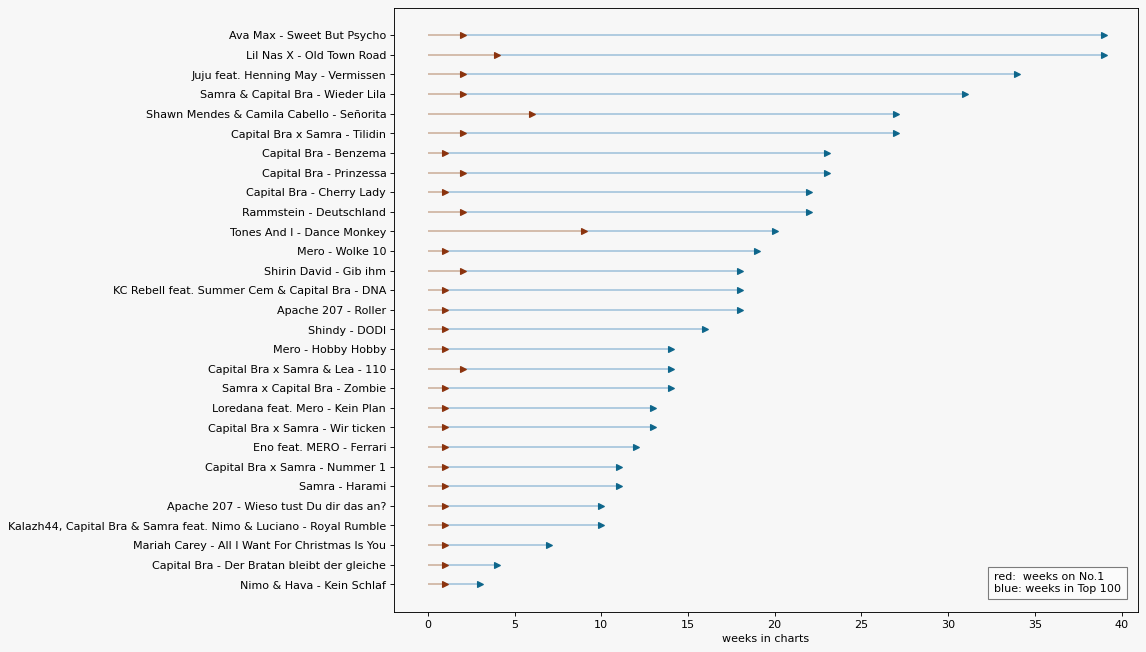

In [771]:
# Draw plot
fig, ax = plt.subplots(1,1,figsize=(12,10), facecolor='#f7f7f7', dpi= 80)

# Plot weeks in charts
plt.hlines(y=weeks['artist_song'], xmin=0, xmax=weeks['weeks_in_charts'], color='#a3c4dc')
plt.plot(weeks['weeks_in_charts'], weeks['artist_song'], ">", color='#0e668b')

# Plot weeks on 1
plt.hlines(y=weeks['artist_song'], xmin=0, xmax=weeks['weeks_on_one'], color='#dcbba3')
plt.plot(weeks['weeks_on_one'], weeks['artist_song'], ">", color='#8b330e')

ax.set_facecolor('#f7f7f7')
ax.set_xlabel('weeks in charts')
plt.figtext(0.75, 0.15, "red:  weeks on No.1\nblue: weeks in Top 100", ha="left", fontsize=10, bbox={"facecolor":"white", "alpha":0.5, "pad":5})

plt.show()

## Song Titles

In [676]:
import itertools
import collections
import nltk
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [712]:
# removing special characters
special_characters = ['!', '?', '#', '/', '(', ')', '&', '%', '$', '*', '+']
title = charts.song

for char in special_characters:
    title = title.str.replace(char, '')

In [717]:
# extract words from song titles
#words_in_title = [song.lower().split() for song in title.unique()]     # for words in unique titles
words_in_title = [song.lower().split() for song in title]               # for words in titles depending appearance in charts
words_in_title[:5]

[['benzema'],
 ['all', 'i', 'want', 'for', 'christmas', 'is', 'you'],
 ['last', 'christmas'],
 ['sweet', 'but', 'psycho'],
 ['driving', 'home', 'for', 'christmas']]

In [718]:
# List of all words across title
all_words = list(itertools.chain(*words_in_title))

# Create counter
count_words = collections.Counter(all_words)

# Remove stopwords
stop_words = set(stopwords.words(['english', 'german']))

# Add Christmas to stopword
stop_words.update(['christmas'])

titles_nsw = [[word for word in title_words if not word in stop_words]
              for title_words in words_in_title]

all_words = list(itertools.chain(*titles_nsw))

# count word without stopword
counts_nsw = collections.Counter(all_words)

# Top ten most used words
counts_nsw.most_common(10)

[('la', 121),
 ('love', 117),
 ('bad', 80),
 ('let', 57),
 ('back', 56),
 ('someone', 55),
 ('like', 54),
 ('heart', 53),
 ('500', 51),
 ('ps', 51)]

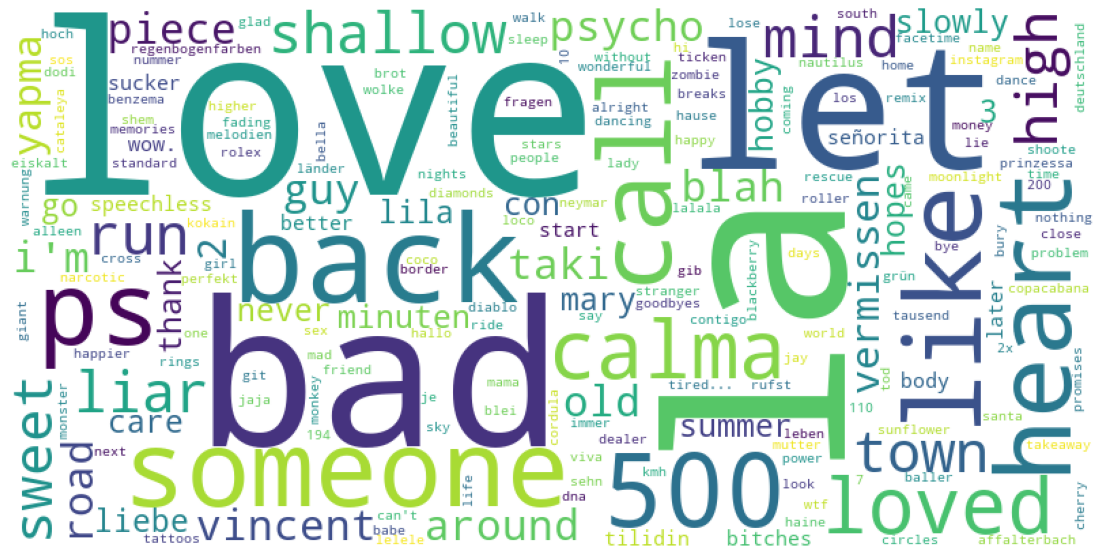

In [719]:
# Create and generate a word cloud image:
wordcloud = WordCloud(
                max_font_size=180,
                max_words=200,
                stopwords=stop_words,
                background_color="white",
                width=800,
                height=400
                ).fit_words(counts_nsw)

# Display the generated image:
plt.figure(figsize=(20,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# Uncomment to save image
#plt.savefig('wordcloud.png', facecolor='k', bbox_inches='tight')

# Save the image in the img folder:
#wordcloud.to_file("2019_titles.png")

In [829]:
#charts[charts['song'].str.contains('Christmas')].groupby(['song']).max().sort_values(by='position', ascending=True)

## Artists

In [804]:
charts.head()

,artist,song,label,position,start_date,end_date,week,artist_song,peak,top10
0,Capital Bra,Benzema,Universal Domestic Urban,1,2018-12-28,2019-01-03,52,Capital Bra - Benzema,1.0,1
1,Mariah Carey,All I Want For Christmas Is You,SME - Columbia,2,2018-12-28,2019-01-03,52,Mariah Carey - All I Want For Christmas Is You,1.0,1
2,Wham!,Last Christmas,SME - Epic,3,2018-12-28,2019-01-03,52,Wham! - Last Christmas,2.0,1
3,Ava Max,Sweet But Psycho,Atlantic,4,2018-12-28,2019-01-03,52,Ava Max - Sweet But Psycho,1.0,1
4,Chris Rea,Driving Home For Christmas,Warner Music International,5,2018-12-28,2019-01-03,52,Chris Rea - Driving Home For Christmas,5.0,1


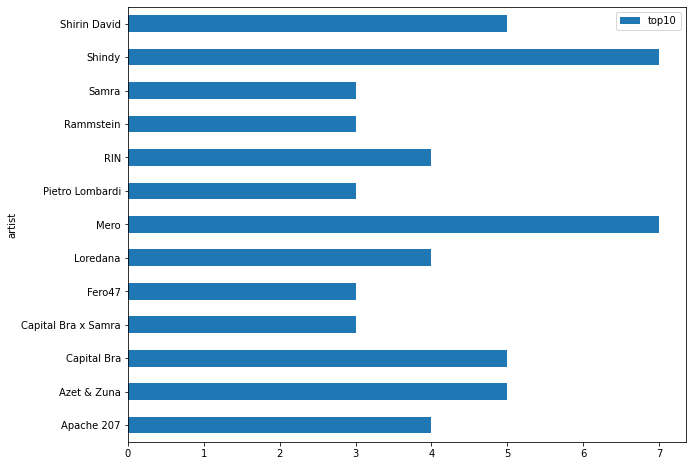

In [821]:
top10 = charts[charts['top10'] == 1]
top10_artist = top10.groupby(['artist', 'song']).count().groupby(['artist']).count()[['top10']]
top10_artist[top10_artist['top10']>=3].plot(kind='barh', figsize=(10, 8))

In [836]:
charts['artist_song'].nunique()

791